In [ ]:
%%time
%%capture cap
%%bash

apt install tree
pip install geopandas
pip install netCDF4
# https://github.com/SciTools/cartopy/issues/1490
apt-get -qq install python-cartopy python3-cartopy
pip uninstall -y shapely
pip install --no-binary shapely shapely --force
pip install --no-binary cartopy cartopy==0.17.0
pip install git+https://github.com/tkrajina/srtm.py

CPU times: user 171 ms, sys: 26.4 ms, total: 197 ms
Wall time: 37.5 s


In [ ]:
%cd /content/drive/My Drive/Posgrado/Geophysics/Colab/Machine_Learning/test

/content/drive/My Drive/Posgrado/Geophysics/Colab/Machine_Learning/test


In [ ]:
# https://geoportal.dane.gov.co/servicios/descarga-y-metadatos/descarga-mgn-marco-geoestadistico-nacional/
%%shell

wget -nc 'https://geoportal.dane.gov.co/descargas/mgn_2020/MGN2020_DPTO_POLITICO.rar'
wget -nc 'https://geoportal.dane.gov.co/descargas/mgn_2020/MGN2020_MPIO_POLITICO.rar'

mkdir 'MGN2020'
unrar -o- x 'MGN2020_DPTO_POLITICO.rar' 'MGN2020'
unrar -o- x 'MGN2020_MPIO_POLITICO.rar' 'MGN2020'

tree -a MGN*/

File ‘MGN2020_DPTO_POLITICO.rar’ already there; not retrieving.

File ‘MGN2020_MPIO_POLITICO.rar’ already there; not retrieving.

mkdir: cannot create directory ‘MGN2020’: File exists

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from MGN2020_DPTO_POLITICO.rar

No files to extract

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from MGN2020_MPIO_POLITICO.rar

No files to extract
MGN2020/
├── Colombia.cpg
├── Colombia.dbf
├── Colombia.shp
├── Colombia.shx
├── MGN_DPTO_POLITICO.CPG
├── MGN_DPTO_POLITICO.dbf
├── MGN_DPTO_POLITICO.prj
├── MGN_DPTO_POLITICO.sbn
├── MGN_DPTO_POLITICO.sbx
├── MGN_DPTO_POLITICO.shp
├── MGN_DPTO_POLITICO.shp.xml
├── MGN_DPTO_POLITICO.shx
├── MGN_MPIO_POLITICO.CPG
├── MGN_MPIO_POLITICO.dbf
├── MGN_MPIO_POLITICO.prj
├── MGN_MPIO_POLITICO.sbn
├── MGN_MPIO_POLITICO.sbx
├── MGN_MPIO_POLITICO.shp
├── MGN_MPIO_POLITICO.shp.xml
├── MGN_MPIO_POLITICO.shx
├── my_rectangle.cpg
├── my_rectangle.dbf
├── my_re

In [ ]:
with open('installs_my_rectangle.txt', 'w') as f:
    f.write(cap.stdout)
%ls -altrh

total 122M
-rw------- 1 root root 9.6M Sep 18  2020  MGN2020_DPTO_POLITICO.rar
-rw------- 1 root root  54M Sep 18  2020  MGN2020_MPIO_POLITICO.rar
-rw------- 1 root root    0 Dec  3  2020  conda_installs.txt
-rw------- 1 root root 6.2K Dec  6  2020  turbo_colormap_data.npy
-rw------- 1 root root  14K Dec  6  2020  turbo_colormap_mpl.py
-rw------- 1 root root  16K Dec  7  2020 'Neural Network_diff_test_hist.pdf'
-rw------- 1 root root  17K Dec  7  2020 'Neural Network_diff_train_hist.pdf'
-rw------- 1 root root 462K Dec  7  2020  colomb97.csv
-rw------- 1 root root  787 Dec  7  2020  colomb97_corr.csv
-rw------- 1 root root  14K Dec  7  2020  colomb97_heatmap.pdf
-rw------- 1 root root 1.2M Dec  7  2020  colomb97_pairplot.pdf
-rw------- 1 root root 304K Dec  7  2020  colomb97_train.csv
-rw------- 1 root root 153K Dec  7  2020  colomb97_test.csv
-rw------- 1 root root 363K Dec  8  2020  LinearReg_diff_train.csv
-rw------- 1 root root  16K Dec  8  2020  LinearReg_diff_train_hist.pdf
-rw--

In [ ]:
import os, sys
sys.path.append("/usr/local/lib/python3.6/site-packages")
from IPython.display import set_matplotlib_formats, display
from io import StringIO
import requests

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
set_matplotlib_formats('pdf', 'svg')
from matplotlib import style
#style.use('classic')

# https://github.com/tkrajina/srtm.py
import srtm
elevation_data = srtm.get_data()
get_elevation_vectorized = np.vectorize(
    elevation_data.get_elevation,
    otypes=[float]
    )

import fiona
import geopandas as gpd
from shapely.geometry import Point, MultiPolygon
from shapely.geometry.polygon import Polygon
from shapely.geometry import shape
from shapely.geometry import mapping
from shapely.ops import unary_union
from netCDF4 import Dataset as netcdf_dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy import config
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# https://github.com/SciTools/cartopy/issues/1120#issuecomment-424418760
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

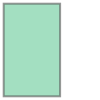

In [ ]:
rectangle = Polygon(
    [[-75.25,6.85],
     [-75.92,6.85],
     [-75.92,5.75],
     [-75.25,5.75]]
     )
display(rectangle)

# https://gis.stackexchange.com/a/52708
# https://stackoverflow.com/a/61109050

# Define a polygon feature geometry with one attribute
schema = {
    'geometry': 'Polygon',
    'properties': {'Name': 'str'}
    }

# Write a new Shapefile
with fiona.open('MGN2020/my_rectangle.shp', 'w', 'ESRI Shapefile', schema) as c:
    ## If there are multiple geometries, put the "for" loop here
    c.write({
        'geometry': mapping(rectangle),
        'properties': {'Name': 'my_rectangle'}
        })

In [ ]:
%%time

Colombia_gdf = gpd.read_file('MGN2020/Colombia.shp')
display(Colombia_gdf)
Colombia_poly = Colombia_gdf['geometry'].values[0]
display(Colombia_poly)

my_rectangle_gpd = gpd.read_file('MGN2020/my_rectangle.shp')
display(my_rectangle_gpd)
my_rectangle = my_rectangle_gpd['geometry'].values[0]
display(my_rectangle)